# Welcome!

This is a quick demo of LOGos - a system for processing logs to help extract causal insights!

If you would like to take a fuller look at the API, you can read the documentation [here](https://mitdbg.github.io/logos).

In [2]:
import sys
sys.path.append("..")
from src.logos.logos import LOGos

## The Log

For this demo, we will analyze a simple a synthetic log, stored at `demo/demo.log`. This log contains three different log line *templates*, each of which reports the value of one of the variables `x`, `y` and `z`. Here is an example of each line:

```
2023-03-14T20:55:49.234591Z DATA The current line will include the value of z = 100.0
2023-03-14T20:55:49.233591Z DATA Short message with x = 199.05342369055703
2023-03-14T20:55:49.232591Z DATA This is a log message that reports y = 399.82103707673997
```

Each millisecond, we decide whether or not to "flip" the value of `z` between 100 and 200, with probability `1%`. If we end up flipping it, we print a log line that reports the new value (first template above).

Each millisecond, we print the value of `x` (second template above), which is generated each time by taking the most recent value of `z` and adding random noise in `[-1,1]`.

Finally, each millisecond we print the value of `y` with probability `50%`(third template above). The value of `y` is generated each time by taking the most recent value of `z`, multiplying it by `2` and adding random noise in `[-1,1]`.

Our objective is to find what is causing the variation in `y`, while appropriately adjusting for any confounders.


## LOGos: Log Converter

Let's create a LOGos instance and initialize it with the path to the log above.

In [3]:
s = LOGos("demo.log", workdir='.', skip_writeout=True)

### Parsing and tagging variables

We can call the `parse()` function to parse the log into a table using the [Drain](https://logparser.readthedocs.io/en/latest/tools/Drain.html) algorithm. 

The Drain algorithm can first extract named variables from each log line using regular expressions. By default, LOGos provides a single regular expression to capture timestamps in the format shown above, naming the resulting field `Timestamp`, but users can parse additional regular expressions to the `parse()` call as a dictionary, via the `regex_dict` parameter.

Then, the Drain algorithm separated log lines into "templates" and "variables", based on the similarity of each new line to the lines seen before it. You can find more information in the paper.

In [4]:
s.parse()
s.parsed_log.head()

Casting date variables round 2...:   0%|          | 0/15121 [00:00<?, ?it/s]/home/markakis/markos-3.11.9-venv/lib/python3.11/site-packages/tqdm/std.py:917: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)
Casting date variables round 2...: 100%|██████████| 15121/15121 [00:00<00:00, 307932.43it/s]
Casting time variables...: 1it [00:00, 2056.03it/s]
Casting time variables round 2...: 0it [00:00, ?it/s]/home/markakis/markos-3.11.9-venv/lib/python3.11/site-packages/tqdm/std.py:917: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)
Casting time variables round 2...: 0it [00:00, ?it/s]
Detecting identifiers...: 100%|██████████| 4/4 [00:00<00:00, 1714.23it/s]


,TemplateId,Timestamp,43e6c5b5_7,f2e46af4_11,f98340b4_12
0,43e6c5b5,1.678827e+09,100.002860,NaN,NaN
1,f2e46af4,1.678827e+09,NaN,200.189963,NaN
2,43e6c5b5,1.678827e+09,100.812299,NaN,NaN
3,f2e46af4,1.678827e+09,NaN,200.458986,NaN
4,43e6c5b5,1.678827e+09,100.260164,NaN,NaN


Let's take a look at the extracted templates. Indeed, Drain has detected the three templates in the synthetic log. Each template is given a hash-based template ID. For each template, we see that a variable has been detected (at word indices 7, 11 and 12, respectively) and replaced with `<*>` in the template text. 

For each template, we also got a regular expression match at index 0, corresponding to the regular expression that matches timestamps. The timestamps were correspondingly replaced by `<*0>`, since that was the 0th (and only) regular expression we provided.

In [5]:
s.parsed_templates

,TemplateText,TemplateId,VariableIndices,RegexIndices,TemplateExample,Occurrences
0,<*0> DATA Short message with x = <*>,43e6c5b5,[7],[0],<*0> DATA Short message with x = 100.0028596...,10000
1,<*0> DATA This is a log message that reports y...,f2e46af4,[11],[0],<*0> DATA This is a log message that reports y...,5006
2,<*0> DATA The current line will include the va...,f98340b4,[12],[0],<*0> DATA The current line will include the va...,115


We can also look at the extracted variables. For variables that were extracted via a regular expression, like the timestamp, the user has already provided a name (in this case, `Timestamp`). For the rest, a variable name is generated from the corresponding template ID and the index that the variable appear in, within the template. For each variable, we also report the preceding 3 tokens and some example values. 

Since the automatically-generated names are not meaningful, we also allow for each variable to carry a tag. Initial values of these tags are guessed from the preceding tokens of each variable, or using language models. However, the user can also manually edit these tags later on. You can find more information in our paper.

In [6]:
s.parsed_variables

,Name,Tag,TagOrigin,Type,IsUninteresting,Occurrences,Preceding 3 tokens,Examples,From regex
0,Timestamp,Timestamp,4,num,False,15121,[],"[2023-03-14T20:55:49.165591Z, 2023-03-14T20:55...",True
1,43e6c5b5_7,x,0,num,False,10000,"[with, x, =]","[100.00285967800117, 100.81229891323964, 100.2...",False
2,f2e46af4_11,y,0,num,False,5006,"[reports, y, =]","[200.1899632341074, 200.45898567905772, 399.69...",False
3,f98340b4_12,z,0,num,False,115,"[of, z, =]","[200.0, 100.0]",False


### Defining the causal unit and aggregating

To continue our analysis, we would like to structure and complete the parsed information to form "causal units", which will be the units on which our causal analysis will be performed. If we think of causality in other contexts, the causal units could be patients in a medical context, or individuals in an economic/social study.

Causal units are defined by one of the available attributes. In a medical context, this could be "patient name". In a systems context, we could pick one of the variables parsed from the log. This decision should come from the user's domain knowledge.  The user can then call `set_causal_unit()`. For example, the call below indicates that each causal unit should be a `1 ms`-long time interval (not that this choice may not be appropriate in every setting):

In [7]:
s.set_causal_unit("Timestamp", num_units=10000)

Given the causal unit, we can then ask Sawmill to perpare the log for analysis by using `prepare()`. Preparing the log involves two distinct tasks:

1. Aggregation: Based on our choice of causal unit, there might be variables that take a multitude of values on different log lines associated with the same causal unit. For example, had we chosen a 10ms window as our causal unit, there would have been 10 lines reporting values of `x`. From this multitude of values, a fixed set of values must be derived (e.g. we could always keep the mean, or the last value seen). By default, Sawmill will generate the `min`, `max` and `mean` for numerical variables; the most recent value for string variables; and the least recent value for date-typed variables.

2. Imputation: On the other end of the spectrum, there might be variables that are never observed within some causal unit. For example, `z` is only reported every approximately `100 ms`, so it should be missing most of the time, if our causal unit is a `1 ms` window. Whether and how to impute such missing values is application-dependent, since we must avoid information leakage from one causal unit to another or risk violating SUTVA. In this case, we know that `z` should be interpreted as a "sticky" value, but `x` and `y` should not be imputed.

After aggregating and imputing, we drop any causal units that still have missing values.

In [8]:
imputation_functions = {'z': 'ffill_imp'}
aggregation_functions = {'Timestamp': ['max']}
s.prepare(custom_agg=aggregation_functions, custom_imp=imputation_functions, force=True)
s.prepared_log.head(10)

Imputing missing values...: 100%|██████████| 9/9 [00:00<00:00, 3004.99it/s]
One-hot encoding categorical variables...: 0it [00:00, ?it/s]


,43e6c5b5_7+mean,f2e46af4_11+mean,f98340b4_12+mean
Timestamp+max,,,
1678827349.170591,199.659262,399.690577,200.0
1678827349.173591,199.755998,400.227124,200.0
1678827349.175591,200.098576,400.083430,200.0
1678827349.178591,200.158634,399.188180,200.0
1678827349.179591,200.934658,400.514334,200.0
1678827349.181591,199.626578,399.894171,200.0
1678827349.182591,200.937334,400.577257,200.0
1678827349.183591,199.831092,399.077464,200.0
1678827349.188591,199.372097,399.650472,200.0


In [9]:
s.prepared_variables

,Name,Base,Pre-agg Value,Agg,Post-agg Value,Tag,Base Variable Occurences,Type,Examples,From regex,TemplateText
0,43e6c5b5_7+mean,43e6c5b5_7,,mean,,x mean,10000,num,"[100.00285967800117, 100.81229891323964, 100.2...",False,<*0> DATA Short message with x = <*>
1,f2e46af4_11+mean,f2e46af4_11,,mean,,y mean,5006,num,"[200.1899632341074, 200.45898567905772, 399.69...",False,<*0> DATA This is a log message that reports y...
2,f98340b4_12+mean,f98340b4_12,,mean,,z mean,115,num,"[200.0, 100.0]",False,<*0> DATA The current line will include the va...


This dataset can now serve as the input to LOGos's two human-in-the-loop modules.

## LOGos: Candidate Cause Ranker

In this variable, we iteratively pick the variable that interests us and ask the system for candidate causes for it. Remember from our data generation process, that `y` appears to be roughly equal to `2x`, but that both `x` and `y` are in fact driven by the value of `z`:

In [10]:
ranking, latency = s.rank_candidate_causes('y mean')
ranking

,Candidate,Candidate Tag,Target Tag,Slope,P-value,Candidate->Target Edge Status,Target->Candidate Edge Status
0,43e6c5b5_7+mean,x mean,y mean,1.999968,0.0,Undecided,Undecided
1,f98340b4_12+mean,z mean,y mean,2.000228,0.0,Undecided,Undecided


As expected, the system cannot meaningfully distinguish between the impact of `x` and `z` on `y`, since `x` is essentially a slightly noisy version of `z`. Both are reported with similar relationship strengths. However, based on our domain knowledge, `x` is a more plausible cause of `y`, so we accept it into the graph:


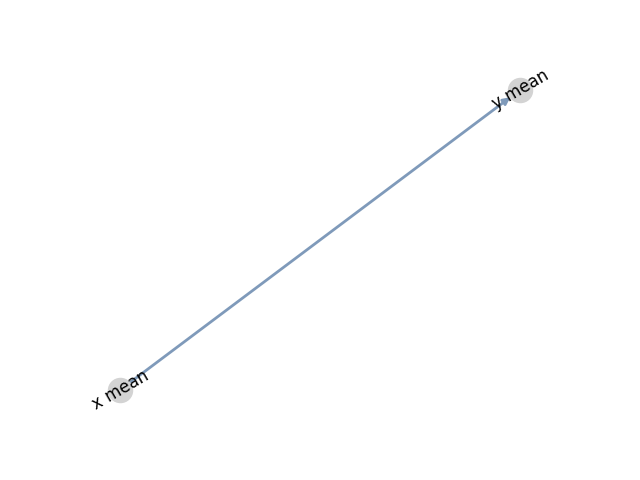

(np.float64(0.3333333333333333), '43e6c5b5_7+mean', '')

In [11]:
s.accept('x mean', 'y mean')

We can then use LOGos to calculate the average treatment effect of `x mean` on `y mean`:

In [12]:
s.get_adjusted_ate('x mean', 'y mean')

## LOGos: Interactive Causal Graph Refiner

However, accepting this ATE value would be still premature. There may be other log variables that confound the observed effect. To determine such variables, we can use the following function to receive pairs of variables into which we should take a closer look. We can then choose what edge, if any, to add between them. 

In [13]:
(src,dst), latency = s.get_causal_graph_refinement_suggestion(treatment='x mean', outcome='y mean')
(src,dst)

('z mean', 'x mean')


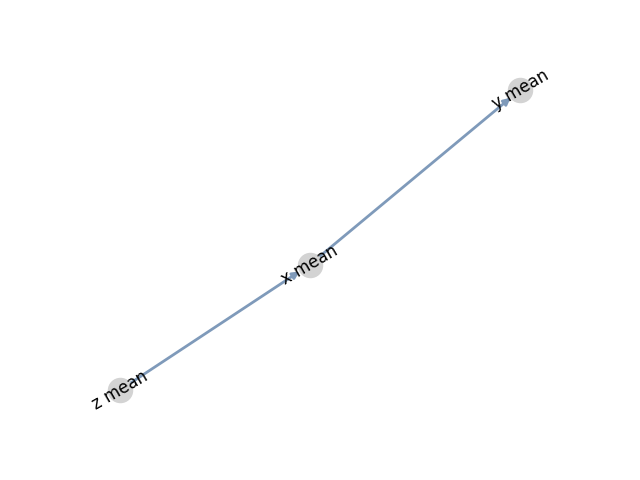

(np.float64(0.6666666666666666), 'f2e46af4_11+mean', '')

In [14]:
s.accept(src, dst)

We can continue this process as long as we receive suggestions that lead to graph edits.

In [15]:
(src,dst), latency = s.get_causal_graph_refinement_suggestion(treatment='x mean', outcome='y mean')
(src,dst)

('z mean', 'y mean')


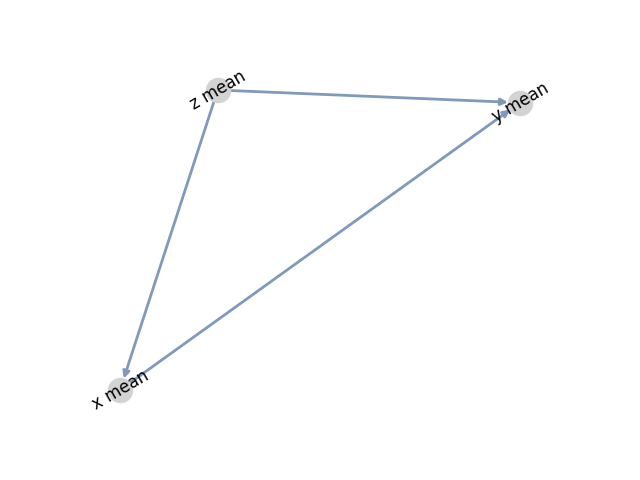

(np.float64(1.0), None, '')

In [16]:
s.accept(src, dst)

We can then calculate the correctly adjusted ATE:

In [17]:
s.get_adjusted_ate('x mean', 'y mean')